In [213]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Contribution Analysis

In this session, how does each feature contribute to random forest decision making will be analysed. 
## 1. Load feature contribution matrix and group by cluster id

In [214]:
fc_df = pd.read_pickle('data/fc_df.pkl')

In [215]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.067839,398
1,0.058480,684
2,0.927992,2097
3,0.077778,360
4,0.895210,668
5,0.889313,262


**Cluster 0,2,3** are unemployed groups. **Cluster 1,4,5** are employed groups. 


### Load original survey data

In [ ]:
sv = survey('data/survey2')
sv.num_processor()

In [271]:
df = pd.concat([sv.data[sv.num_cols[:-1]],sv.fin_data.educom,sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f31 = fc_df.columns[:31]
df31= df[f31]
l = list(df31.columns)
l.append('cluster')

new = np.column_stack((df31.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

## Unemployed Clusters

### Cluster 0

In [217]:
c0 = fc_df[fc_df.cluster == 0]

In [218]:
sort_feature_means(c0,10)

[(-0.10317282437223002, 'coninc'),
 (-0.03392890421279629, 'age'),
 (-0.027697984375685748, 'class_'),
 (-0.02329553524837526, 'agekdbrn'),
 (-0.019737805836251204, 'polviews'),
 (-0.019516568518921647, 'educom'),
 (0.018331218255143, 'degree'),
 (-0.017661640918404647, 'finrela'),
 (-0.016754120832062, 'partyid'),
 (-0.014698778319805235, 'dwelling')]

In [275]:
df_c0 = df[df.cluster ==0]

In [292]:
df.head()

,coninc,age,educom,degree,sphrs1,partyid,agekdbrn,class_,dwelling,polviews,...,natroad,fechld,helpoth,parsol,chldidel,workhard,mawrkgrw,meovrwrk,employed,cluster
0,16137,21,12.3333,High school,Not applicable,Strong democrat,Not applicable,Lower class,Apartment-4 stories,Conservative,...,About right,Not applicable,3rd important,Not applicable,Not applicable,2nd important,No,Neither agree nor disagree,True,4
1,121553,30,13.6667,Bachelor,50,Not str democrat,27,Upper class,Apartment-4 stories,Liberal,...,About right,Disagree,Not applicable,Not applicable,2,Not applicable,No,Not applicable,False,2
2,121553,41,15,Bachelor,80,"Ind,near dem",38,Upper class,Row house,Slghtly conservative,...,Too little,Disagree,3rd important,Much better,2,2nd important,Yes,Not applicable,False,1
3,64546,25,14,Graduate,Not applicable,Not str republican,20,Upper class,Apartment house,Liberal,...,Don't know,Strongly agree,Not applicable,Not applicable,2,Not applicable,Yes,Not applicable,False,1
4,0,29,5,High school,Not applicable,Independent,18,Middle class,Apartment-4 stories,Conservative,...,About right,Agree,Not applicable,Not applicable,3,Not applicable,Yes,Disagree,False,0


In [298]:
df.age.unique()

array([21, 30, 41, 25, 29, 34, 33, 38, 26, 36, 44, 40, 51, 39, 56, 49, 27,
       45, 24, 32, 46, 53, 31, 37, 43, 42, 35, 28, 47, 18, 63, 20, 55, 76,
       54, 65, 22, 48, 23, 62, 64, 70, 50, 60, 52, 66, 19, 58, 75, 59, 67,
       57, 61, 68, 69, 80, 71, 77, 81, 73], dtype=object)

In [297]:
sv.num_cols

['sphrs1', 'age', 'agekdbrn', 'chldidel', 'coninc', 'educom']

In [299]:
df_c0.sphrs1.value_counts()

Not applicable    285
40                 52
50                 12
60                  9
70                  6
45                  4
80                  4
30                  4
55                  3
89                  3
24                  2
20                  2
35                  2
65                  2
Don't know          1
84                  1
16                  1
39                  1
44                  1
54                  1
4                   1
67                  1
Name: sphrs1, dtype: int64

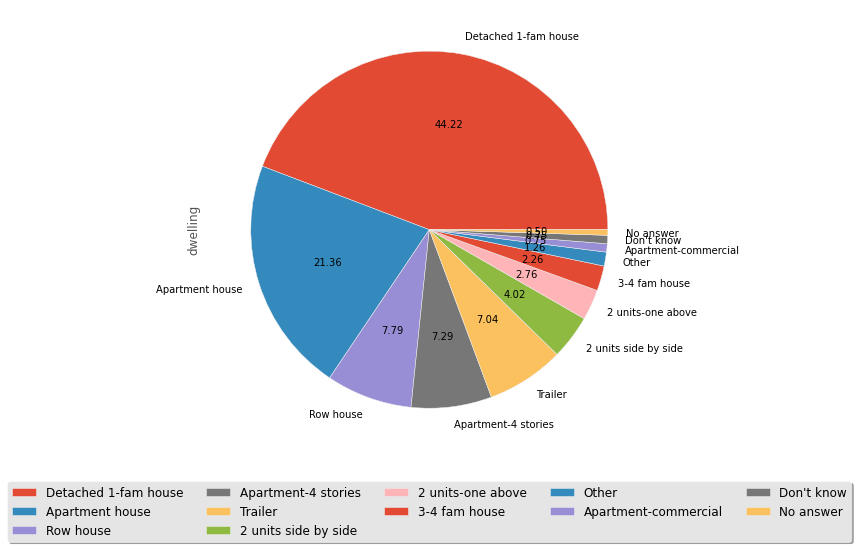

In [231]:
simple_pie(df_c0.dwelling)

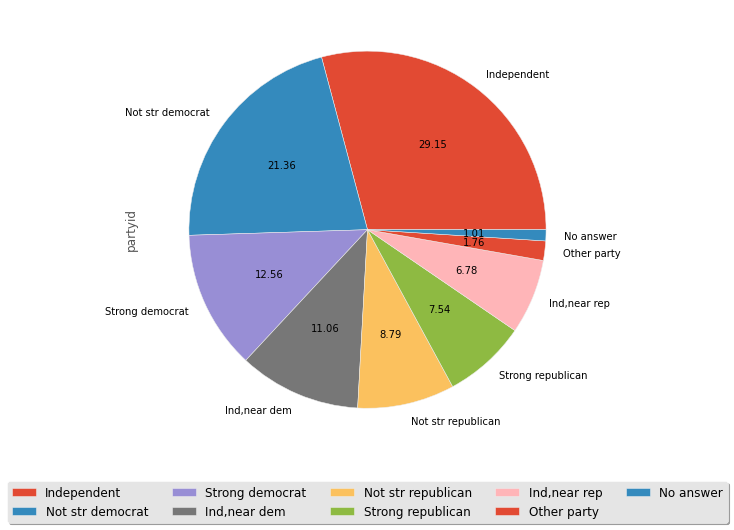

In [224]:
simple_pie(df_c0.partyid)

In [225]:
df_c0.describe().ix[2:,:].T

,top,freq
coninc,0,90
age,34,25
educom,12.3333,137
degree,High school,328
sphrs1,98,285
partyid,Independent,116
agekdbrn,98,46
class_,Working class,160
dwelling,Detached 1-fam house,176
polviews,Moderate,144


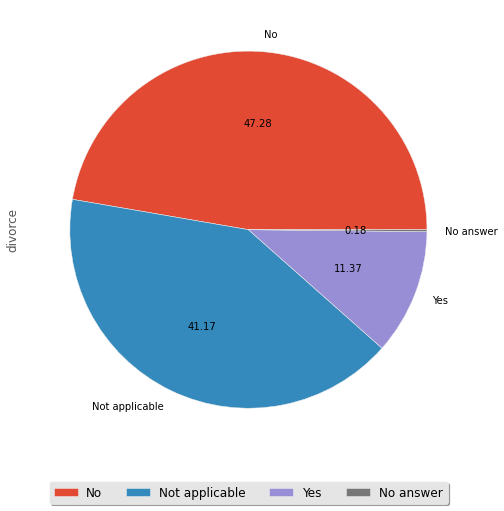

In [226]:
simple_pie(df.divorce)

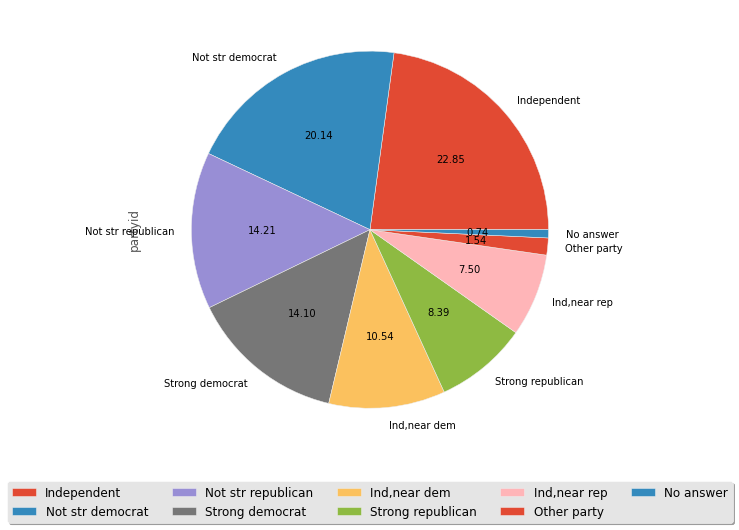

In [227]:
simple_pie(df.partyid)

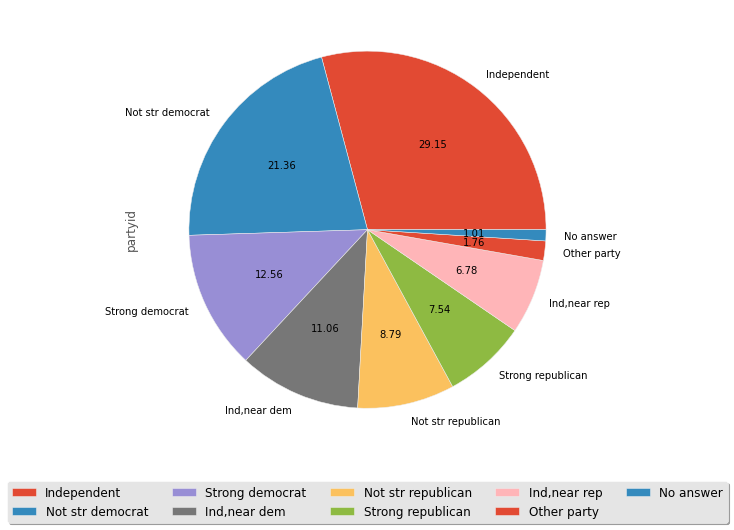

In [228]:
simple_pie(df_c0.partyid)